# 03 - Scraping Audio Data from Spotify
Spotify maintains a set of audio features for each song, including metrics like loudness, energy, valence, instrumentalness, danceability, etc. These features can be obtained through querying Spotify's API.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import spotipy
import spotipy.util
import os
import pickle as pkl
import re

from importlib import reload
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

print('setup complete')

setup complete


## Authorization

In [2]:
def get_auth_token(username, client_id, client_secret, redirect_uri):
    try:
        os.remove(f".cache-{username}")
    except:
        None
        
    token = spotipy.util.prompt_for_user_token(
        username, client_id=client_id, client_secret=client_secret,
        redirect_uri=redirect_uri)

    return token

In [3]:
credentials = {
    'username': 'thivux', 
    'client_id': 'e7b98fd19cae4bc581b4ee6daa313caa',
    'client_secret': '843d11eb3e5c4da9a1ce1b4faa6fc1c6', 
    'redirect_uri': 'http://localhost:8888/'
}

In [4]:
# define data directory where credentials and data (old and new) are stored
data_dir = os.path.join('..','data')
token = get_auth_token(**credentials)
print('authorization complete')

done


## Query Spotify

In [5]:
def query_spotify(songs_df, token, verbose=False):
    """
    Function queries the spotifyAPI, by using the artist name and the song title
    :param filepath: str | filepath
    :return: pd.DataFrame | dataframe with the audio features from the spotifyAPI
    """
    # search for track + name
    audio_features_df = pd.DataFrame()
    
    failed = []
    for index, row in songs_df.iterrows():
        name = row['song_clean']
        artist = row['artist_clean']
        year = row['year']
        try:
            spotify = spotipy.Spotify(auth=token)
            results = spotify.search(
                q='track:' + name + ' artist:' + artist, type='track',
                limit=1)
            uri = results['tracks']['items'][0]['uri']
            spotify_song = results['tracks']['items'][0]['name']
            album_name = results['tracks']['items'][0]['album']['name']
            sp_artist = results['tracks']['items'][0]['artists'][0]['name']
            popularity = results['tracks']['items'][0]['popularity']
            release_date = results['tracks']['items'][0]['album']['release_date']
            explicit = results['tracks']['items'][0]['explicit']
            
            if verbose:
                print('successfully queried song {}: {} by {}'.format(index, name, artist))

            audio_feat = spotify.audio_features(uri)
            x = audio_feat[0]
            x.pop('analysis_url')
            x.pop('track_href')
            x['spotify_song'] = spotify_song
            x['spotify_album'] = album_name
            x['spotify_artist'] = sp_artist
            x['billboard_name'] = name
            x['billboard_artist'] = artist
            x['popularity'] = popularity
            x['release_date'] = release_date
            x['explicit'] = explicit
            x['billboard_df_index'] = index
            
            audio_features_df = audio_features_df.append(x, ignore_index=True)
        except:
            if verbose:
                print('failed song {}: {} by {}'.format(index, name, artist, year))
            failed.append([name, artist, year])
            None
            
    failed = pd.DataFrame(failed, columns=['song', 'artist', 'year'])
    return audio_features_df, failed

In [6]:
billboard = pd.read_csv('../data/billboard-lyrics-full.csv')
print(billboard.shape)
billboard.sample(3)

(6301, 11)


index      artist_all     artist_base  rank  \
1358     57  johnnie taylor  johnnie taylor    58   
3559     58      elton john      elton john    59   
2045     44   cliff richard   cliff richard    45   

                                      song  year artist_featured  \
1358  i believe in you (you believe in me)  1973             NaN   
3559                               believe  1995             NaN   
2045                 we don't talk anymore  1980             NaN   

                              song_clean    artist_clean  \
1358  i believe in you you believe in me  johnnie taylor   
3559                             believe      elton john   
2045                we dont talk anymore   cliff richard   

                                                 lyrics          source  
1358  i feel sorry i feel sorry i feel sorry i feel ...  songlyrics.com  
3559   i believe in love its all we got love has no ...      genius.com  
2045  used to think that life was sweet used to thin...      genius.com

In [7]:
df2, failed = query_spotify(billboard, token, verbose=True)

successfully queried song 0: theme from a summer place by percy faith
successfully queried song 1: hell have to go by jim reeves
successfully queried song 2: cathys clown by the everly brothers
successfully queried song 3: running bear by johnny preston
successfully queried song 4: teen angel by mark dinning
successfully queried song 5: im sorry by brenda lee
successfully queried song 6: its now or never by elvis presley
successfully queried song 7: handy man by jimmy jones
successfully queried song 8: stuck on you by elvis presley
successfully queried song 9: the twist by chubby checker
successfully queried song 10: everybodys somebodys fool by connie francis
successfully queried song 11: wild one by bobby rydell
successfully queried song 12: greenfields by the brothers four
successfully queried song 13: what in the worlds come over you by jack scott
successfully queried song 14: el paso by marty robbins
successfully queried song 15: alley oop by the hollywood argyles
successfully que

In [8]:
# number of failed songs
billboard.shape[0] - df2.shape[0]

148

In [9]:
failed

song  \
0                                         tracys theme   
1                                           asia minor   
2                                        teen age idol   
3    love me with all your heart cuando calienta el...   
4                                                  gto   
..                                                 ...   
143                                        10000 hours   
144                                    pussy fairy otw   
145                                leave the door open   
146                                               3435   
147                              smokin out the window   

                      artist  year  
0               spencer ross  1960  
1               jimmy wisner  1961  
2               ricky nelson  1962  
3    the ray charles singers  1964  
4     ronny and the daytonas  1964  
..                       ...   ...  
143                dan  shay  2020  
144               jhene aiko  2020  
145               silk sonic  2021  
146            ariana grande  2021  
147               silk sonic  2022  

[148 rows x 3 columns]

## Failed queries 

Unable to query 148 songs for audio features


findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: Generic family 'serif' not found because none of the following families were found: times new roman
findfont: 

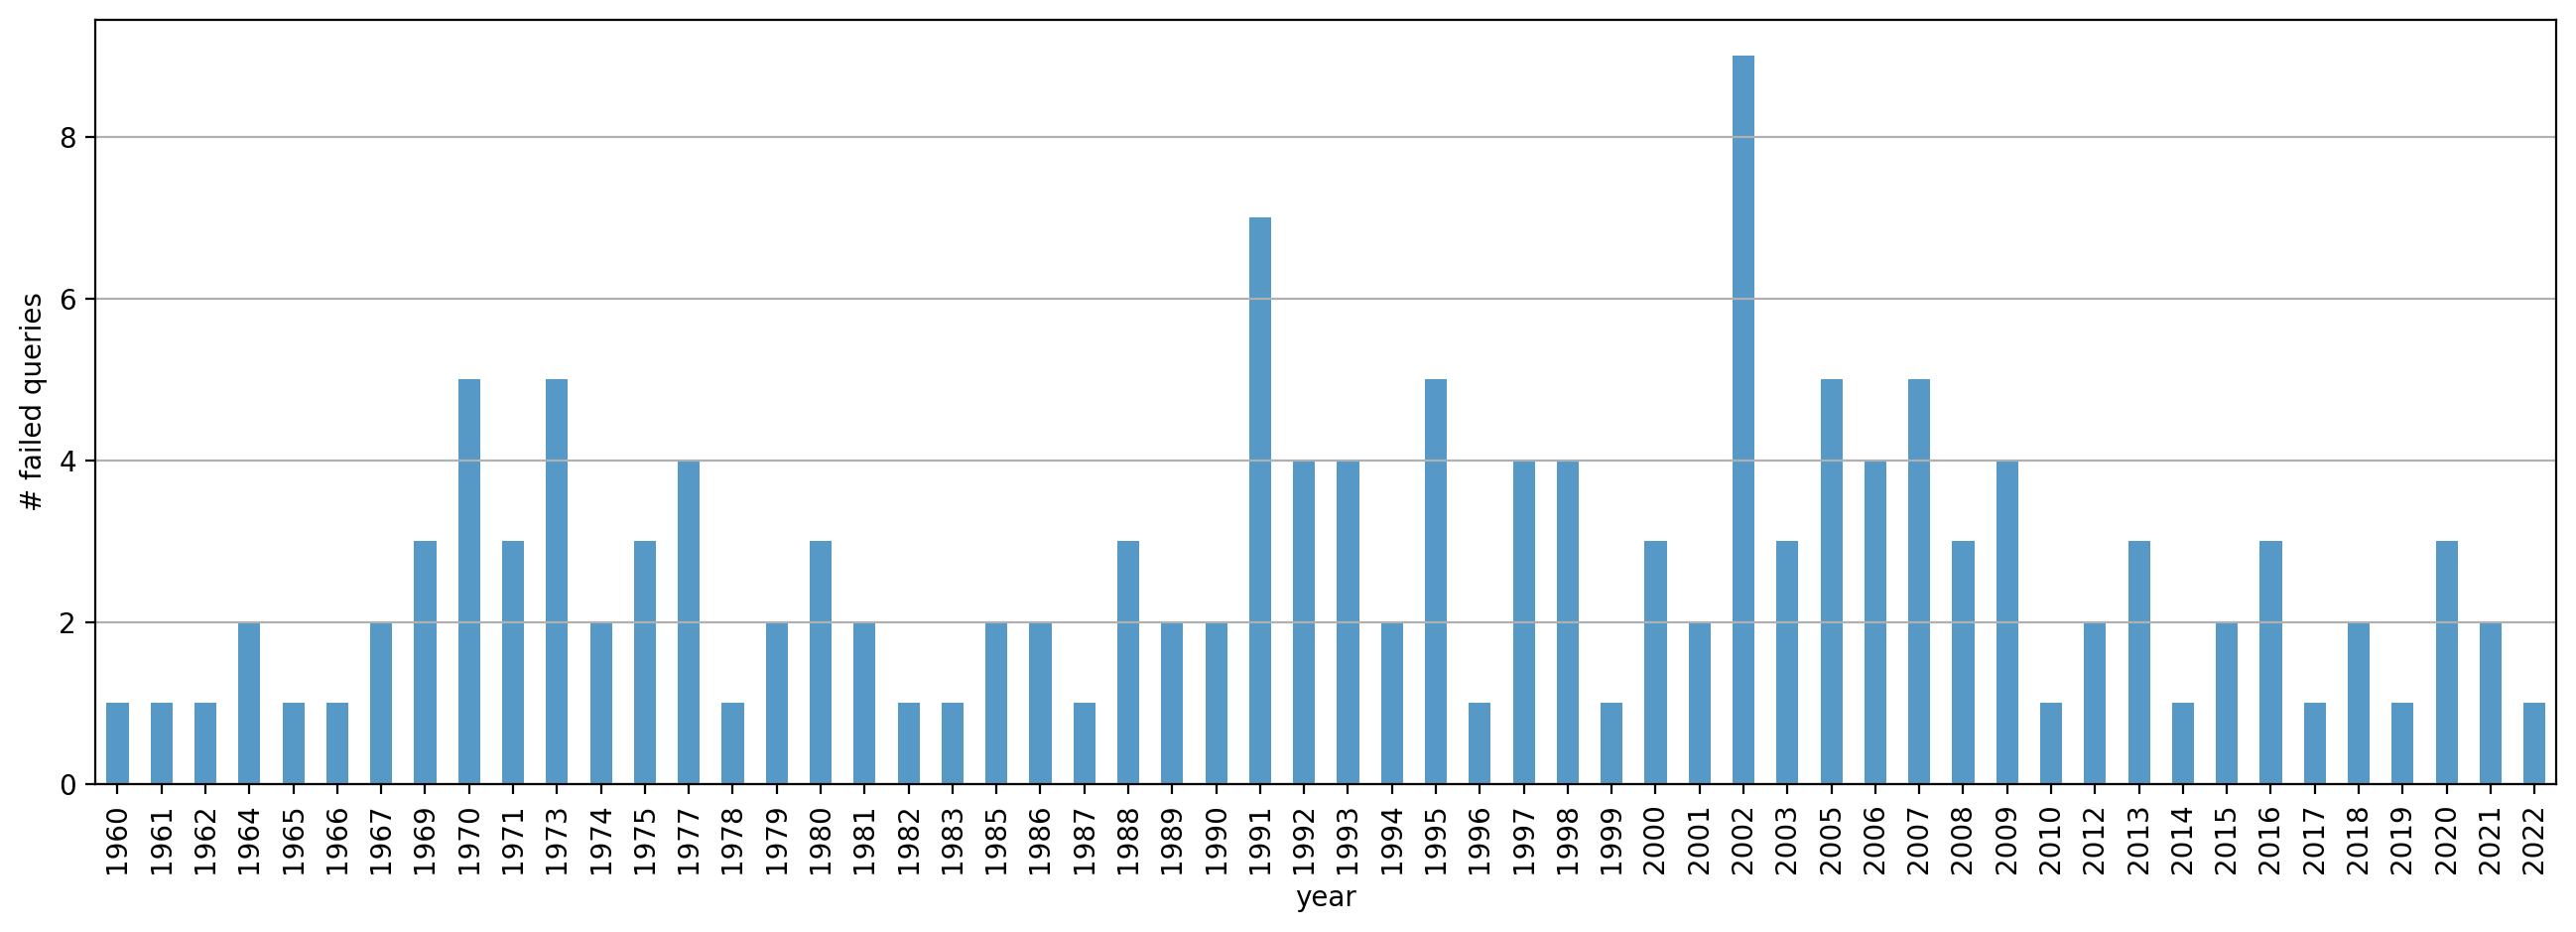

In [10]:
print('Unable to query {} songs for audio features'.format(len(failed)))

ax = failed.year\
           .value_counts()\
           .sort_index()\
           .plot.bar(figsize = (16,5), alpha=0.75);
ax.yaxis.grid(True);
ax.set(xlabel = 'year', ylabel = '# failed queries');

## Save Spotify data

In [14]:
df2.to_csv('../data/features.csv', index=False)

## Combine with Billboard and lyrics data

In [23]:
# df1 and df2 have different sizes because of unsuccessful queries
# therefore, we must merge on respective indices
billboard = pd.read_csv('../data/billboard-lyrics-full.csv')
df2 = pd.read_csv('../data/features.csv')
df1 = billboard.copy().drop(['index'], axis=1).reset_index()
df1['index'] = df1['index'].astype(float)
df_merge = pd.merge(df1, df2, how='left', left_on='index', right_on='billboard_df_index')

# billboard name and artist are copies of song and artist_base for verifying
# merge consistency and can be removed
column_mask = df_merge.columns.str.contains('billboard')
df_merge = df_merge.loc[:, ~column_mask]

# unnecessary to keep
df_merge = df_merge.drop(
    ['index', 'source', 'id', 'type', 'uri', 'spotify_artist',
     'spotify_song', 'spotify_album', 'release_date'], axis=1)

df_merge.head(2)

artist_all  artist_base  rank                       song  year  \
0  percy faith  percy faith     1  theme from a summer place  1960   
1   jim reeves   jim reeves     2           he'll have to go  1960   

  artist_featured                 song_clean artist_clean  \
0             NaN  theme from a summer place  percy faith   
1             NaN            hell have to go   jim reeves   

                                              lyrics  danceability  energy  \
0  theres a summer place where it may rain or sto...         0.213   0.324   
1  put your sweet lips a little closer to the pho...         0.429   0.283   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0  9.0   -13.823   0.0       0.0304         0.450            0.3830    0.0728   
1  0.0   -13.566   1.0       0.0401         0.934            0.0495    0.1070   

   valence    tempo  duration_ms  time_signature  popularity explicit  
0    0.557  181.746     165214.0             3.0        54.0    False  
1    0.124   79.076     142427.0             3.0        51.0    False

## Create derived features

In [24]:
df_merge['lyrics']

0       theres a summer place where it may rain or sto...
1       put your sweet lips a little closer to the pho...
2        dont want your love any more dont want your k...
3       on the bank of the river stood running bear yo...
4       teen angel teen angel teen angel that fateful ...
                              ...                        
6296     its a beautiful day shes been crying all nigh...
6297     sit by myself talking to the moon teh ha pull...
6298     mummy dont know daddys getting hot at the bod...
6299     you and i had this off and on so long youve b...
6300     i swear i dont know how i trusted a montero w...
Name: lyrics, Length: 6301, dtype: object

In [25]:
# convert duration to more manageable units and drop original feature
df_merge['duration_min'] = df_merge['duration_ms'] / 1000 / 60
df_merge = df_merge.drop('duration_ms', axis=1)

# count number of words for each song
df_merge['num_words'] = df_merge['lyrics'].apply(
    lambda x: len(x.split()) if not isinstance(x, float) else np.nan)

# measure number of words per second for each song
df_merge['words_per_sec'] = df_merge['num_words'] /\
    (df_merge['duration_min'] * 60)

# count number of unique words for each song
df_merge['num_uniq_words'] = df_merge['lyrics'].apply(
    lambda x: pd.Series(
        x.split()).nunique() if not isinstance(x, float) else np.nan)

# convert years to decade for each song (but without dropping original feature)
df_merge['decade'] = df_merge['year'] // 10 * 10

# measure ratio of total words to unique words for each song
df_merge['uniq_ratio'] = df_merge['num_uniq_words']/df_merge['num_words']
df_merge.tail()

artist_all   artist_base  rank  \
6296  ernest  featuring  morgan wallen        ernest    96   
6297        jnr choi  and sam tompkins      jnr choi    97   
6298          sam smith and kim petras     sam smith    98   
6299                        kane brown    kane brown    99   
6300                      maren morris  maren morris   100   

                          song  year artist_featured  \
6296              flower shops  2022   morgan wallen   
6297               to the moon  2022             NaN   
6298                    unholy  2022             NaN   
6299           one mississippi  2022             NaN   
6300  circles around this town  2022             NaN   

                    song_clean  artist_clean  \
6296              flower shops        ernest   
6297               to the moon      jnr choi   
6298                    unholy     sam smith   
6299           one mississippi    kane brown   
6300  circles around this town  maren morris   

                                                 lyrics  danceability  energy  \
6296   its a beautiful day shes been crying all nigh...         0.527   0.461   
6297   sit by myself talking to the moon teh ha pull...         0.745   0.650   
6298   mummy dont know daddys getting hot at the bod...         0.714   0.472   
6299   you and i had this off and on so long youve b...         0.471   0.846   
6300   i swear i dont know how i trusted a montero w...         0.591   0.814   

      key  loudness  mode  speechiness  acousticness  instrumentalness  \
6296  7.0    -5.908   1.0       0.0269       0.11800          0.000000   
6297  2.0   -11.814   1.0       0.3460       0.04510          0.007580   
6298  2.0    -7.375   1.0       0.0864       0.01300          0.000005   
6299  0.0    -5.269   1.0       0.0389       0.00279          0.000003   
6300  4.0    -4.986   1.0       0.0468       0.01500          0.000000   

      liveness  valence    tempo  time_signature  popularity explicit  \
6296    0.0831    0.227  128.153             3.0        71.0    False   
6297    0.1110    0.386  144.047             4.0        74.0     True   
6298    0.2660    0.238  131.121             4.0        91.0    False   
6299    0.1450    0.539  100.089             4.0        65.0    False   
6300    0.1170    0.815  149.900             4.0        57.0    False   

      duration_min  num_words  words_per_sec  num_uniq_words  decade  \
6296      3.573417      167.0       0.778900            80.0    2020   
6297      2.535617      241.0       1.584099            42.0    2020   
6298      2.615717      167.0       1.064081            82.0    2020   
6299      3.561983      167.0       0.781400            97.0    2020   
6300      3.262667      169.0       0.863302           108.0    2020   

      uniq_ratio  
6296    0.479042  
6297    0.174274  
6298    0.491018  
6299    0.580838  
6300    0.639053

## Final processing

In [26]:
# normalize artist name for beyonce
df_merge['artist_clean'] = df_merge['artist_clean'].replace('beyonce knowles', 'beyonce')

# strip whitespace at beginning and ends of artist columns
artist_cols = ['artist_base', 'artist_all', 'artist_featured', 'artist_clean']
df_merge[artist_cols] = df_merge[artist_cols].applymap(
    lambda x: x.strip() if not isinstance(x, float) else np.nan)
df_merge.shape

(6301, 29)

## Save combined data

In [27]:
df_merge.to_csv('../data/billboard-lyrics-spotify.csv', index=False)

In [28]:
df_merge['lyrics'].isna().sum()

51